In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from scipy.signal import TransferFunction, lsim, tf2ss

import scipy
import os
import control

SAVE_PATH = 'report/figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
plt.rcParams['figure.figsize'] = [4, 4]

In [16]:
# var 17
a_1, a_0 = 2, 4
b_1, b_0 = 3, 5
k_1, k_0 = 4, 4
u = lambda t : np.sin(t) + 0.5 * np.cos(2 * t)

# Task 1

In [369]:
theta = np.array([k_0 - a_0, k_1 - a_1, b_0, b_1])

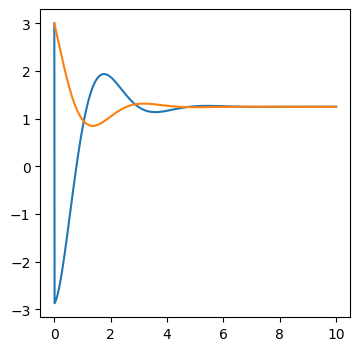

In [401]:
class OmegaVector():
    def __init__(self, denum_ks, n, m, y0, u0, theta) -> None:
        u0 = np.array([u0])
        parts = y0 / sum(theta**2)
        self.n = n
        self.m = m
        self.num = [1]
        self.denum_ks = denum_ks
        self.omega = [tf2ss(self.num + [0] * i, denum_ks) for i in range(n)]
        self.omega += [tf2ss(self.num + [0] * i, denum_ks) for i in range(m)]
        self.systems_xs = []
        self.y = np.array([y0]).reshape(1, 1)
        parts = np.array([parts]).reshape(1, 1)
        for i in range(self.n):
            A, B, C, D = self.omega[i]
            x0 = np.linalg.pinv(C) @ (parts * theta[i] - D * u0)
            self.systems_xs.append(x0)
        for i in range(self.n, self.n + self.m):
            A, B, C, D = self.omega[i]
            x0 = np.linalg.pinv(C) @ (parts * theta[i] - D * u0)
            self.systems_xs.append(x0)
    
    def model(self, ts, us, theta):
        ys = np.zeros(self.m + self.n)
        dt = ts[1] - ts[0]
        res = [self.y.reshape(-1)[-1]]
        for idx in range(len(ts) - 1):
            for i in range(self.n):
                A, B, C, D = self.omega[i]
                A, B, C, D, _ = scipy.signal.cont2discrete((A, B, C, D), dt)
                self.systems_xs[i] = A @ self.systems_xs[i] + B * self.y
                ys[i] = C @ self.systems_xs[i] + D @ self.y
            for i in range(self.n, self.n + self.m):
                A, B, C, D = self.omega[i]
                A, B, C, D, _ = scipy.signal.cont2discrete((A, B, C, D), dt)
                self.systems_xs[i] = A @ self.systems_xs[i] + B * us[idx]
                ys[i] = C @ self.systems_xs[i] + D * u[idx]
            res.append(theta.T @ ys)
            self.y = np.array(res[-1]).reshape(1, 1)
        return res

y0 = 3
theta = np.array([k_0 - a_0, k_1 - a_1, b_0, b_1])
ts = np.linspace(0, 10, 1000)
u = np.ones_like(ts).reshape((len(ts), 1))
ov = OmegaVector(denum_ks=[1, k_1, k_0], n=2, m=2, y0=y0, u0=u[0], theta=theta)
res = ov.model(ts, u, theta)
plt.plot(ts, res)

sptf = TransferFunction([b_1, b_0], [1, a_1, a_0])
A, B, C, D = tf2ss([b_1, b_0], [1, a_1, a_0])
x0 = np.linalg.pinv(C) @ (np.array([y0]) - D * 1)
t, y, x = lsim(sptf, U=u, T=ts, X0=x0.reshape(-1))
plt.plot(t, y)

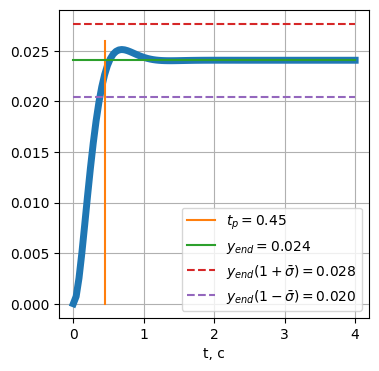

In [4]:
tf = scipy.signal.TransferFunction([1], [1, 1.41 * omega_0, omega_0**2]).to_ss()
ts = np.linspace(0, 4, 100)
t, y, _ = scipy.signal.lsim(tf, U = [1] * 100, T = ts )
end = y[-10:].mean()

plt.plot(t, y, linewidth=5)
plt.plot([t_p] * 100, np.linspace(0, 0.026, 100), label=f'$t_p = {t_p}$')
plt.plot(ts, [end.mean()] * 100, label=f'$y_{"{end}"} = {end: .3f}$')
plt.plot(ts, [end * (1 + sigma_bar)] * 100, label=f'$y_{"{end}"} (1 + \\bar \sigma) = {end * (1 + sigma_bar): .3f}$', linestyle='dashed')
plt.plot(ts, [end * (1 - sigma_bar)] * 100, label=f'$y_{"{end}"} (1 - \\bar \sigma) = {end * (1 - sigma_bar): .3f}$', linestyle='dashed')
plt.xlabel('t, c')

plt.legend()
plt.grid()
plt.savefig(SAVE_PATH + '1.png')

# Task 2

In [5]:
A_m, B_m, C_m, D_m = tf.to_ss().A, tf.to_ss().B, tf.to_ss().C, tf.to_ss().D
A_m, B_m, C_m, D_m = np.rot90(A_m, k=2), np.rot90(B_m, k=2), np.rot90(C_m, k=2), np.rot90(D_m, k=2)
A_m, A, B_m

(array([[  0.        ,   1.        ],
        [-41.5308642 ,  -9.08666667]]),
 array([[ 0,  1],
        [-1,  7]]),
 array([[0.],
        [1.]]))

In [6]:
theta = -((-A_m[-1, :] + A[-1, :]) / b_0).reshape(A.shape[0], 1)
kappa = b_0 / B_m[-1, 0] 
theta, kappa

(array([[-5.06635802],
        [-2.01083333]]),
 8.0)

In [7]:
def model(t, x, A, B, g):
    return A@x + (B * g(t)).reshape(A.shape[0])

t_span = [0, 20]
y0 = np.array([0, 0])
data_model= solve_ivp(model, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(A_m, B_m, g))

In [8]:
def system(t, x, A, B, theta, kappa, g):
    u = theta.T @ x + 1 / kappa * g(t)
    return A@x + (B * u).reshape(A.shape[0])

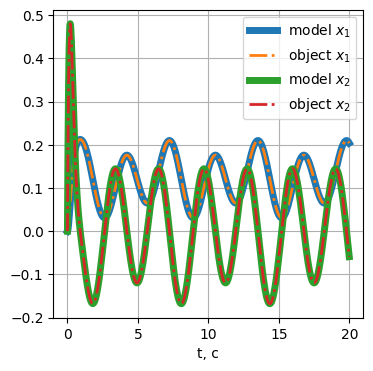

In [9]:
data = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(A, B, theta, kappa, g))
plt.plot(data.t, data_model.y[0, :], linewidth=5, label='model $x_1$')
plt.plot(data.t, data.y[0, :], '-.', linewidth=2, label='object $x_1$')
plt.plot(data.t, data_model.y[1, :], linewidth=5, label='model $x_2$')
plt.plot(data.t, data.y[1, :], '-.', linewidth=2, label='object $x_2$')
plt.grid()
plt.legend()
plt.xlabel('t, c')

plt.savefig(SAVE_PATH + '2_ideal_x.png')

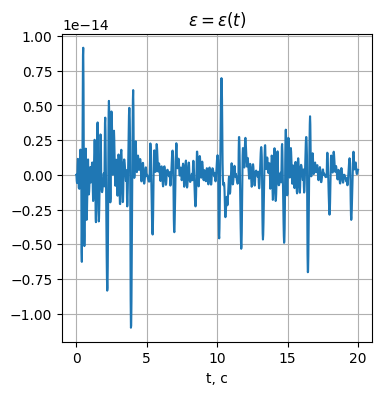

In [10]:
plt.plot(data.t, (C @ data.y).reshape(-1) - (C_m @ data_model.y).reshape(-1))
plt.grid()
plt.xlabel('t, c')
plt.title('$\epsilon = \epsilon(t)$')

plt.savefig(SAVE_PATH + '2_ideal_e.png')

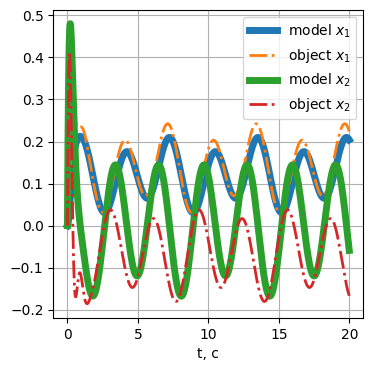

In [11]:
data = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(A + 1, B, theta, kappa, g))

plt.plot(data.t, data_model.y[0, :], linewidth=5, label='model $x_1$')
plt.plot(data.t, data.y[0, :], '-.', linewidth=2, label='object $x_1$')
plt.plot(data.t, data_model.y[1, :], linewidth=5, label='model $x_2$')
plt.plot(data.t, data.y[1, :], '-.', linewidth=2, label='object $x_2$')
plt.grid()
plt.legend()
plt.xlabel('t, c')


plt.savefig(SAVE_PATH + '2_not_ideal_1_x.png')

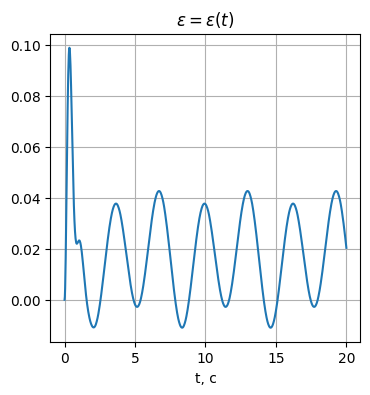

In [12]:
plt.plot(data.t, (C @ data.y).reshape(-1) - (C_m @ data_model.y).reshape(-1))
plt.grid()
plt.xlabel('t, c')
plt.title('$\epsilon = \epsilon(t)$')

plt.savefig(SAVE_PATH + '2_not_ideal_1_e.png')

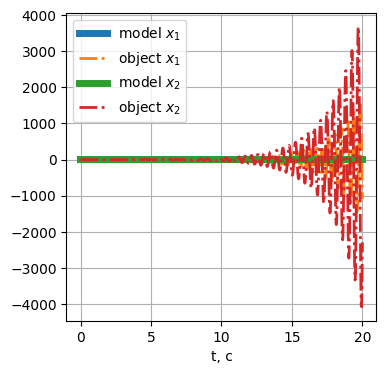

In [13]:
data = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(A + 5, B, theta, kappa, g))

plt.plot(data.t, data_model.y[0, :], linewidth=5, label='model $x_1$')
plt.plot(data.t, data.y[0, :], '-.', linewidth=2, label='object $x_1$')
plt.plot(data.t, data_model.y[1, :], linewidth=5, label='model $x_2$')
plt.plot(data.t, data.y[1, :], '-.', linewidth=2, label='object $x_2$')
plt.grid()
plt.legend()
plt.xlabel('t, c')

plt.savefig(SAVE_PATH + '2_bad_5_x.png')

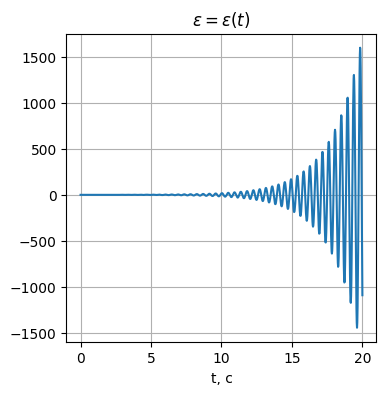

In [14]:
plt.plot(data.t, (C @ data.y).reshape(-1) - (C_m @ data_model.y).reshape(-1))
plt.grid()
plt.xlabel('t, c')
plt.title('$\epsilon = \epsilon(t)$')

plt.savefig(SAVE_PATH + '2_bad_5_e.png')

# Task 3

In [15]:
Q = np.diag([0.1, 0.2])
P = scipy.linalg.solve_sylvester(A_m.T, A_m, -Q)
P

array([[0.47349502, 0.00120392],
       [0.00120392, 0.01113763]])

In [16]:
def d_theta_hat(x, P, gamma, B, e):
    x = x.reshape(2, 1)
    e = e.reshape(2, 1)
    return (gamma * x @ B.T @ P @ e).reshape(-1)

def system(t, x, A, B, A_m, B_m, kappa, g, gamma):
    theta_hat = x[-2:]
    x_m = x[:2]
    x = x[2:4]
    e = x_m - x
    u = theta_hat.T @ x + 1 / kappa * g(t)
    return np.hstack([model(t, x_m, A_m, B_m, g),
                        A@x + (B * u).reshape(A.shape[0]),
                        d_theta_hat(x, P, gamma, B, e)])

## exp 1

In [17]:
experiment_1 = {}
gamma = 1000
y0 = [0, 0, 0, 0, 0, 0]
t_span = [0, 300]

for bias in [0, 1, 5]:
    tmpA = A.copy()
    tmpA[-1] += bias
    experiment_1[bias] = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(tmpA, B, A_m, B_m, kappa, g, gamma))

In [18]:
for bias in experiment_1:
    t = experiment_1[bias].t
    state =  experiment_1[bias].y
    x_m = state[:2]
    x = state[2:4]
    plt.plot(t, x_m[0,], linewidth=2, label='model $x_1$')
    plt.plot(t, x[0,], '-.', linewidth=1, label='object $x_1$')
    plt.plot(t, x_m[1,], linewidth=2, label='model $x_2$')
    plt.plot(t, x[1,], '-.', linewidth=1, label='object $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$x = x(t)$')
    plt.savefig(SAVE_PATH + f'3_1_{bias}_x.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], x_m[0,][-100:], linewidth=2, label='model $x_1$')
    plt.plot(t[-100:], x[0,][-100:], '-.', linewidth=1, label='object $x_1$')
    plt.plot(t[-100:], x_m[1,][-100:], linewidth=2, label='model $x_2$')
    plt.plot(t[-100:], x[1,][-100:], '-.', linewidth=1, label='object $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$x = x(t)$')
    plt.savefig(SAVE_PATH + f'3_1_{bias}_x_small.png')
    plt.cla()
    plt.close()

In [19]:
for bias in experiment_1:
    t = experiment_1[bias].t
    state =  experiment_1[bias].y
    x_m = state[:2]
    x = state[2:4]
    plt.plot(t, x_m[0,] - x[0,], linewidth=5, label='model $x_1$')
    plt.plot(t, x_m[1,] - x[1,], linewidth=5, label='model $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$e = e(t)$')
    plt.savefig(SAVE_PATH + f'3_1_{bias}_e.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], x_m[0,][-100:] - x[0,][-100:], linewidth=5, label='e $x_1$')
    plt.plot(t[-100:], x_m[1,][-100:] - x[1,][-100:], linewidth=5, label='model $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$e = e(t)$')
    plt.savefig(SAVE_PATH + f'3_1_{bias}_e_small.png')
    plt.cla()
    plt.close()

In [20]:
for bias in experiment_1:
    tmpA = A.copy()
    tmpA[-1] += bias
    theta =  -((-A_m[-1, :] + tmpA[-1, :]) / b_0).reshape(A.shape[0], 1)
    t = experiment_1[bias].t
    state =  experiment_1[bias].y
    theta_tilda = theta - state[-2:]
    
    plt.plot(t, theta_tilda[0,], linewidth=5, label='$\\tilde{\\theta}_1$')
    plt.plot(t, theta_tilda[1,], linewidth=5, label='$\\tilde{\\theta}_2$')
    plt.grid()
    plt.legend()
    plt.title('$\\tilde \\theta = \\tilde \\theta(t)$')
    plt.savefig(SAVE_PATH + f'3_1_{bias}_theta.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], theta_tilda[0][-100:], linewidth=5, label='$\\tilde{\\theta}_1$')
    plt.plot(t[-100:], theta_tilda[1][-100:], linewidth=5, label='$\\tilde{\\theta}_2$')
    plt.grid()
    plt.legend()
    plt.title('$\\tilde \\theta = \\tilde \\theta(t)$')
    plt.savefig(SAVE_PATH + f'3_1_{bias}_theta_small.png')
    plt.cla()
    plt.close()

## exp 2

In [26]:
experiment_2 = {}
y0 = [0, 0, 0, 0, 0, 0]
t_span = [0, 80]
for gamma in [1e-4, 1, 20]:
    experiment_2[gamma] = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(A, B, A_m, B_m, kappa, g, gamma))

In [30]:
for gamma in experiment_2:
    t = experiment_2[gamma].t
    state =  experiment_2[gamma].y
    x_m = state[:2]
    x = state[2:4]
    plt.plot(t, x_m[0,], linewidth=2, label='model $x_1$')
    plt.plot(t, x[0,], '-.', linewidth=1, label='object $x_1$')
    plt.plot(t, x_m[1,], linewidth=2, label='model $x_2$')
    plt.plot(t, x[1,], '-.', linewidth=1, label='object $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$x = x(t)$')
    plt.savefig(SAVE_PATH + f'3_2_{gamma}_x.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], x_m[0,][-100:], linewidth=2, label='model $x_1$')
    plt.plot(t[-100:], x[0,][-100:], '-.', linewidth=1, label='object $x_1$')
    plt.plot(t[-100:], x_m[1,][-100:], linewidth=2, label='model $x_2$')
    plt.plot(t[-100:], x[1,][-100:], '-.', linewidth=1, label='object $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$x = x(t)$')
    plt.savefig(SAVE_PATH + f'3_2_{gamma}_x_small.png')
    plt.cla()
    plt.close()

In [31]:
for gamma in experiment_2:
    t = experiment_2[gamma].t
    state =  experiment_2[gamma].y
    x_m = state[:2]
    x = state[2:4]
    plt.plot(t, x_m[0,] - x[0,], linewidth=5, label='model $x_1$')
    plt.plot(t, x_m[1,] - x[1,], linewidth=5, label='model $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$e = e(t)$')
    plt.savefig(SAVE_PATH + f'3_2_{gamma}_e.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], x_m[0,][-100:] - x[0,][-100:], linewidth=5, label='e $x_1$')
    plt.plot(t[-100:], x_m[1,][-100:] - x[1,][-100:], linewidth=5, label='model $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$e = e(t)$')
    plt.savefig(SAVE_PATH + f'3_2_{gamma}_e_small.png')
    plt.cla()
    plt.close()

In [32]:
for gamma in experiment_2:
    tmpA = A.copy()
    theta =  -((-A_m[-1, :] + tmpA[-1, :]) / b_0).reshape(A.shape[0], 1)
    t = experiment_2[gamma].t
    state =  experiment_2[gamma].y
    theta_tilda = theta - state[-2:]
    
    plt.plot(t, theta_tilda[0,], linewidth=5, label='$\\tilde{\\theta}_1$')
    plt.plot(t, theta_tilda[1,], linewidth=5, label='$\\tilde{\\theta}_2$')
    plt.grid()
    plt.legend()
    plt.title('$\\tilde \\theta = \\tilde \\theta(t)$')
    plt.savefig(SAVE_PATH + f'3_2_{gamma}_theta.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], theta_tilda[0,][-100:], linewidth=5, label='$\\tilde{\\theta}_1$')
    plt.plot(t[-100:], theta_tilda[1,][-100:], linewidth=5, label='$\\tilde{\\theta}_2$')
    plt.grid()
    plt.legend()
    plt.title('$\\tilde \\theta = \\tilde \\theta(t)$')
    plt.savefig(SAVE_PATH + f'3_2_{gamma}_theta_small.png')
    plt.cla()
    plt.close()

## Exp 3

In [33]:
experiment_3 = {}
gamma = 1000
y0 = [0, 0, 0, 0, 0, 0]
t_span = [0, 300]
g = lambda t: 0 * t + 1

for bias in [0, 1, 5]:
    tmpA = A.copy()
    tmpA[-1] += bias
    experiment_3[bias] = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(tmpA, B, A_m, B_m, kappa, g, gamma))
for bias in experiment_3:
    t = experiment_3[bias].t
    state =  experiment_3[bias].y
    x_m = state[:2]
    x = state[2:4]
    plt.plot(t, x_m[0,], linewidth=2, label='model $x_1$')
    plt.plot(t, x[0,], '-.', linewidth=1, label='object $x_1$')
    plt.plot(t, x_m[1,], linewidth=2, label='model $x_2$')
    plt.plot(t, x[1,], '-.', linewidth=1, label='object $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$x = x(t)$')
    plt.savefig(SAVE_PATH + f'3_3_{bias}_x.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], x_m[0,][-100:], linewidth=2, label='model $x_1$')
    plt.plot(t[-100:], x[0,][-100:], '-.', linewidth=1, label='object $x_1$')
    plt.plot(t[-100:], x_m[1,][-100:], linewidth=2, label='model $x_2$')
    plt.plot(t[-100:], x[1,][-100:], '-.', linewidth=1, label='object $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$x = x(t)$')
    plt.savefig(SAVE_PATH + f'3_3_{bias}_x_small.png')
    plt.cla()
    plt.close()
for bias in experiment_3:
    t = experiment_3[bias].t
    state =  experiment_3[bias].y
    x_m = state[:2]
    x = state[2:4]
    plt.plot(t, x_m[0,] - x[0,], linewidth=5, label='model $x_1$')
    plt.plot(t, x_m[1,] - x[1,], linewidth=5, label='model $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$e = e(t)$')
    plt.savefig(SAVE_PATH + f'3_3_{bias}_e.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], x_m[0,][-100:] - x[0,][-100:], linewidth=5, label='e $x_1$')
    plt.plot(t[-100:], x_m[1,][-100:] - x[1,][-100:], linewidth=5, label='model $x_2$')
    plt.grid()
    plt.legend()
    plt.title('$e = e(t)$')
    plt.savefig(SAVE_PATH + f'3_3_{bias}_e_small.png')
    plt.cla()
    plt.close()
for bias in experiment_3:
    tmpA = A.copy()
    tmpA[-1] += bias
    theta =  -((-A_m[-1, :] + tmpA[-1, :]) / b_0).reshape(A.shape[0], 1)
    t = experiment_3[bias].t
    state =  experiment_3[bias].y
    theta_tilda = theta - state[-2:]
    
    plt.plot(t, theta_tilda[0,], linewidth=5, label='$\\tilde{\\theta}_1$')
    plt.plot(t, theta_tilda[1,], linewidth=5, label='$\\tilde{\\theta}_2$')
    plt.grid()
    plt.legend()
    plt.title('$\\tilde \\theta = \\tilde \\theta(t)$')
    plt.savefig(SAVE_PATH + f'3_3_{bias}_theta.png')
    plt.cla()
    plt.close()
    
    plt.plot(t[-100:], theta_tilda[0][-100:], linewidth=5, label='$\\tilde{\\theta}_1$')
    plt.plot(t[-100:], theta_tilda[1][-100:], linewidth=5, label='$\\tilde{\\theta}_2$')
    plt.grid()
    plt.legend()
    plt.title('$\\tilde \\theta = \\tilde \\theta(t)$')
    plt.savefig(SAVE_PATH + f'3_3_{bias}_theta_small.png')
    plt.cla()
    plt.close()
